# State of Languages
In this notebook,
* **projects** refer to [Wikimedia content projects](https://meta.wikimedia.org/wiki/Wikimedia_projects) with linguistic editions: Wikibooks, Wikinews, Wikipedia, Wikiquote, Wikisource, Wikiversity, Wikivoyage, and Wiktionary;
* **hosted projects** refer to projects (as defined above) that have their own domain hosted by the Wikimedia Foundation;
* **test projects** include pre-hosted projects located in
   * Wikimedia Incubator (for Wikibooks, Wikinews, Wikipedia, Wikiquote, Wikivoyage, and Wiktionary)
   * Wikiversity Beta
   * Multilingual Wikisource

## Packages and functions

In [1]:
# Packages
pacman::p_load(tidyverse, here, matrixStats, kableExtra, pollster, 
               # jsonlite, reticulate,
               ggrepel)

In [2]:
## ggplot theme: state of languages (sol) theme ---------
theme_sol <- function(){ 
  theme(plot.title=element_text(size=24), 
        plot.subtitle=element_text(size=18, color="gray"), 
        plot.caption=element_text(size=12, color="dim gray"),
        axis.title=element_blank(), 
        axis.text.y=element_text(size=18), 
        axis.text.x=element_blank(), 
        legend.position="none")  
}

In [3]:
# increase column and row maxes
options(repr.matrix.max.cols=12, repr.matrix.max.rows=1100)

# make plot dimmensions
options(repr.plot.width=16, repr.plot.height=8.5)

In [4]:
#prep to be able to run spark queries using reticulate package
#per https://wikitech.wikimedia.org/wiki/Data_Engineering/Systems/Conda#wmfdata-python_through_reticulate
conda_env_data <- paste(
    system2(
        "conda",
        args = c("info", "-a", "--json"),
        stdout = TRUE),
    collapse = '') |>
    jsonlite::fromJSON()
reticulate::use_condaenv(conda_env_data[['active_prefix']])
wmfdata <- reticulate::import('wmfdata')

## Read data

In [5]:
df_import <- read_tsv(here("04_analysis/outputs/state_of_languages_with_counts_and_notes.tsv"), show_col_types=F)
proj_import <- read_tsv(here("03_wrangled_data/projects.tsv"), show_col_types=F)
lang_import <- read_tsv(here("03_wrangled_data/project_languages.tsv"), show_col_types=F)
nrow(lang_import %>% select(language_name) %>% distinct(.))

[1] 1134

In [6]:
df <- df_import %>% 
  mutate_at(vars(Wikibooks:Wiktionary), ~ str_replace(., "-", "(none)")) #replace dashes with nones

## Metrics

### How many languages have at least _x_ number of hosted projects?

In [7]:
df_hosted <- df

# code for 'at least' number
df_hosted$`at least 1 hosted project` <- ifelse(df_hosted$n_hosted_open>=1, 1, 0)
df_hosted$`at least 2 hosted projects`<- ifelse(df_hosted$n_hosted_open>=2, 1, 0)
df_hosted$`at least 3 hosted projects`<- ifelse(df_hosted$n_hosted_open>=3, 1, 0)
df_hosted$`at least 4 hosted projects`<- ifelse(df_hosted$n_hosted_open>=4, 1, 0)
df_hosted$`at least 5 hosted projects`<- ifelse(df_hosted$n_hosted_open>=5, 1, 0)
df_hosted$`at least 6 hosted projects`<- ifelse(df_hosted$n_hosted_open>=6, 1, 0)
df_hosted$`at least 7 hosted projects`<- ifelse(df_hosted$n_hosted_open>=7, 1, 0)
df_hosted$`all 8 hosted projects`<- ifelse(df_hosted$n_hosted_open>=8, 1, 0)

# trim, gather, and aggregate
df_hosted <- df_hosted %>% 
  select(-c(Wikibooks, Wikinews, Wikipedia, Wikiquote, Wikisource, Wiktionary, Wikiversity, Wikivoyage, n_hosted_open, n_test_closure, n_test_initial, n_all_types, notes)) %>%
  gather(., 2:9, key="Languages with...", value="value")%>%
  dplyr::group_by(`Languages with...`) %>%
  dplyr::summarise(n=sum(value)) %>%
  dplyr::ungroup()

df_hosted %>% arrange(desc(n))

Languages with...          n  
1 at least 1 hosted project  342
2 at least 2 hosted projects 177
3 at least 3 hosted projects  98
4 at least 4 hosted projects  71
5 at least 5 hosted projects  57
6 at least 6 hosted projects  34
7 at least 7 hosted projects  23
8 all 8 hosted projects       13

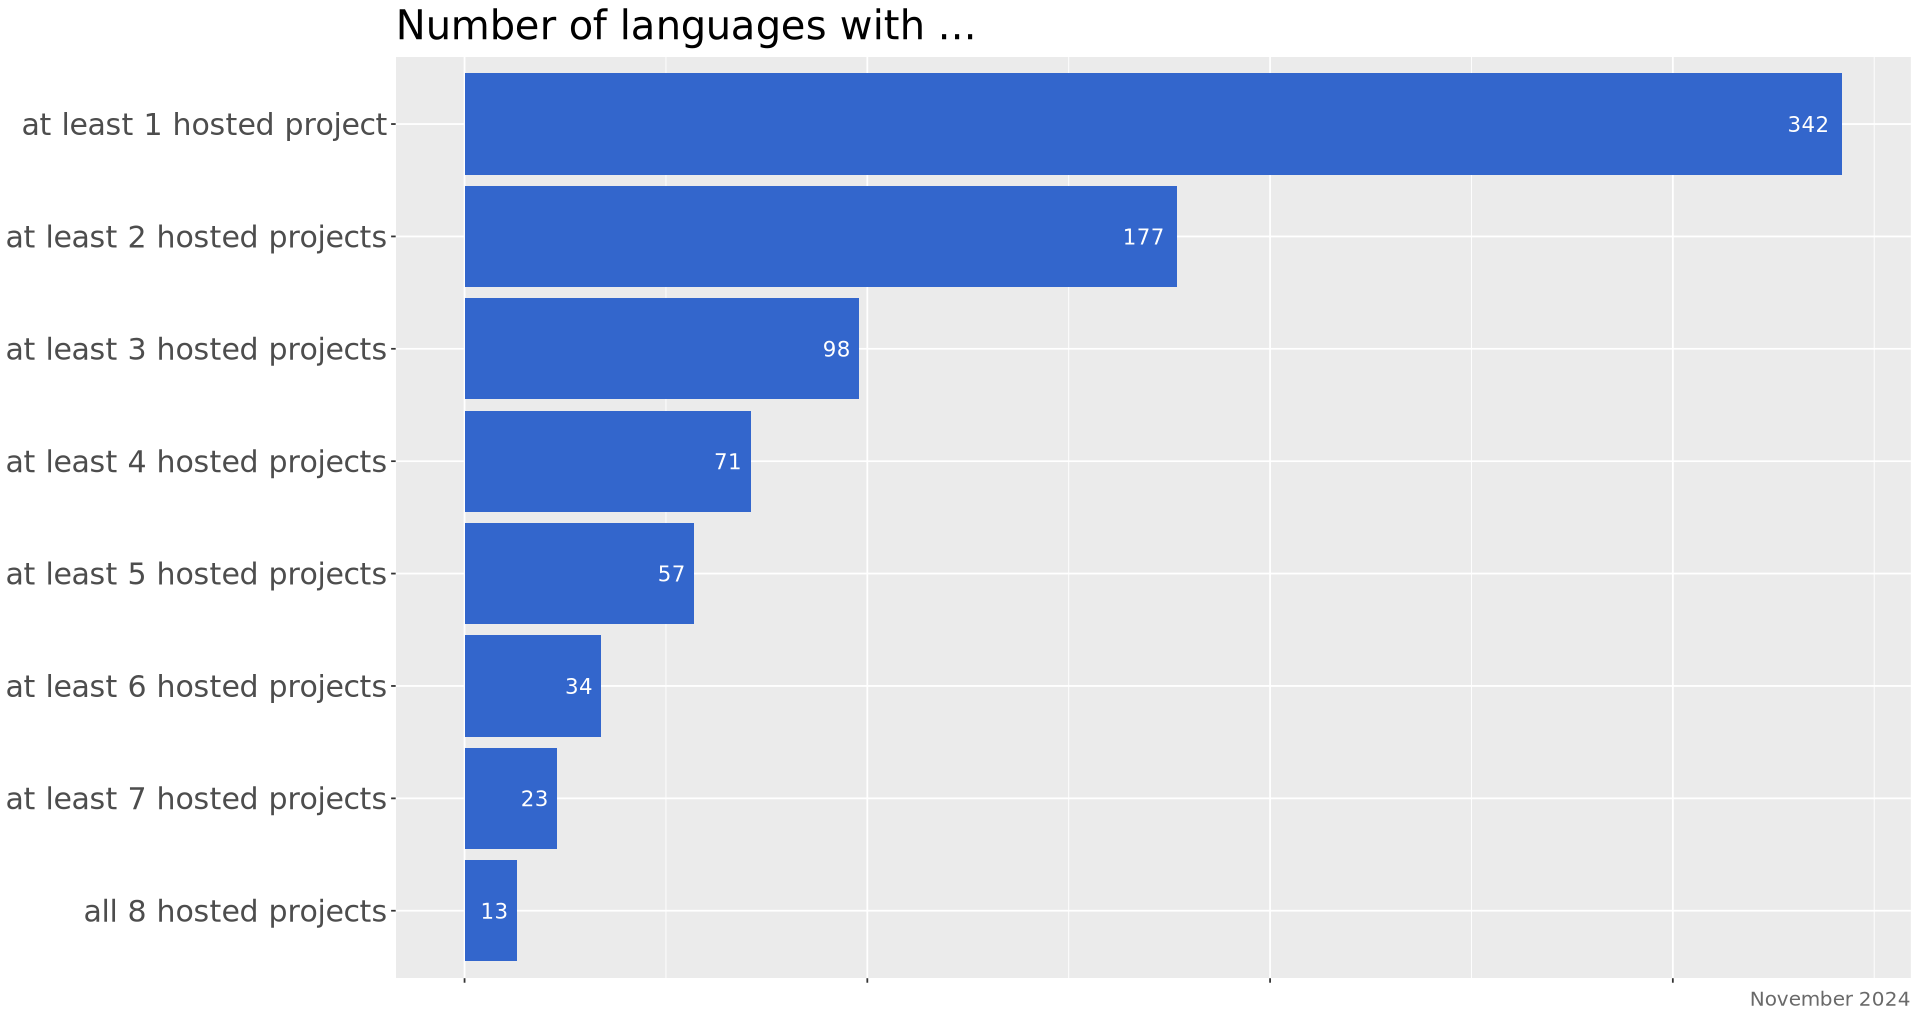

In [8]:
# Plot
#options(repr.plot.width=10, repr.plot.height=9)
df_hosted %>% ggplot(aes(x=reorder(`Languages with...`,n), y=n)) + 
  geom_bar(position = position_dodge(), stat="identity", fill = "#3366CC") +
  labs(title="Number of languages with ...",
      caption="November 2024") +
  theme_sol() + 
  geom_text(aes(label = n), hjust = 1.3, color="white", size=4.5) +
  coord_flip()

### How many languages have _x_ number of hosted projects?

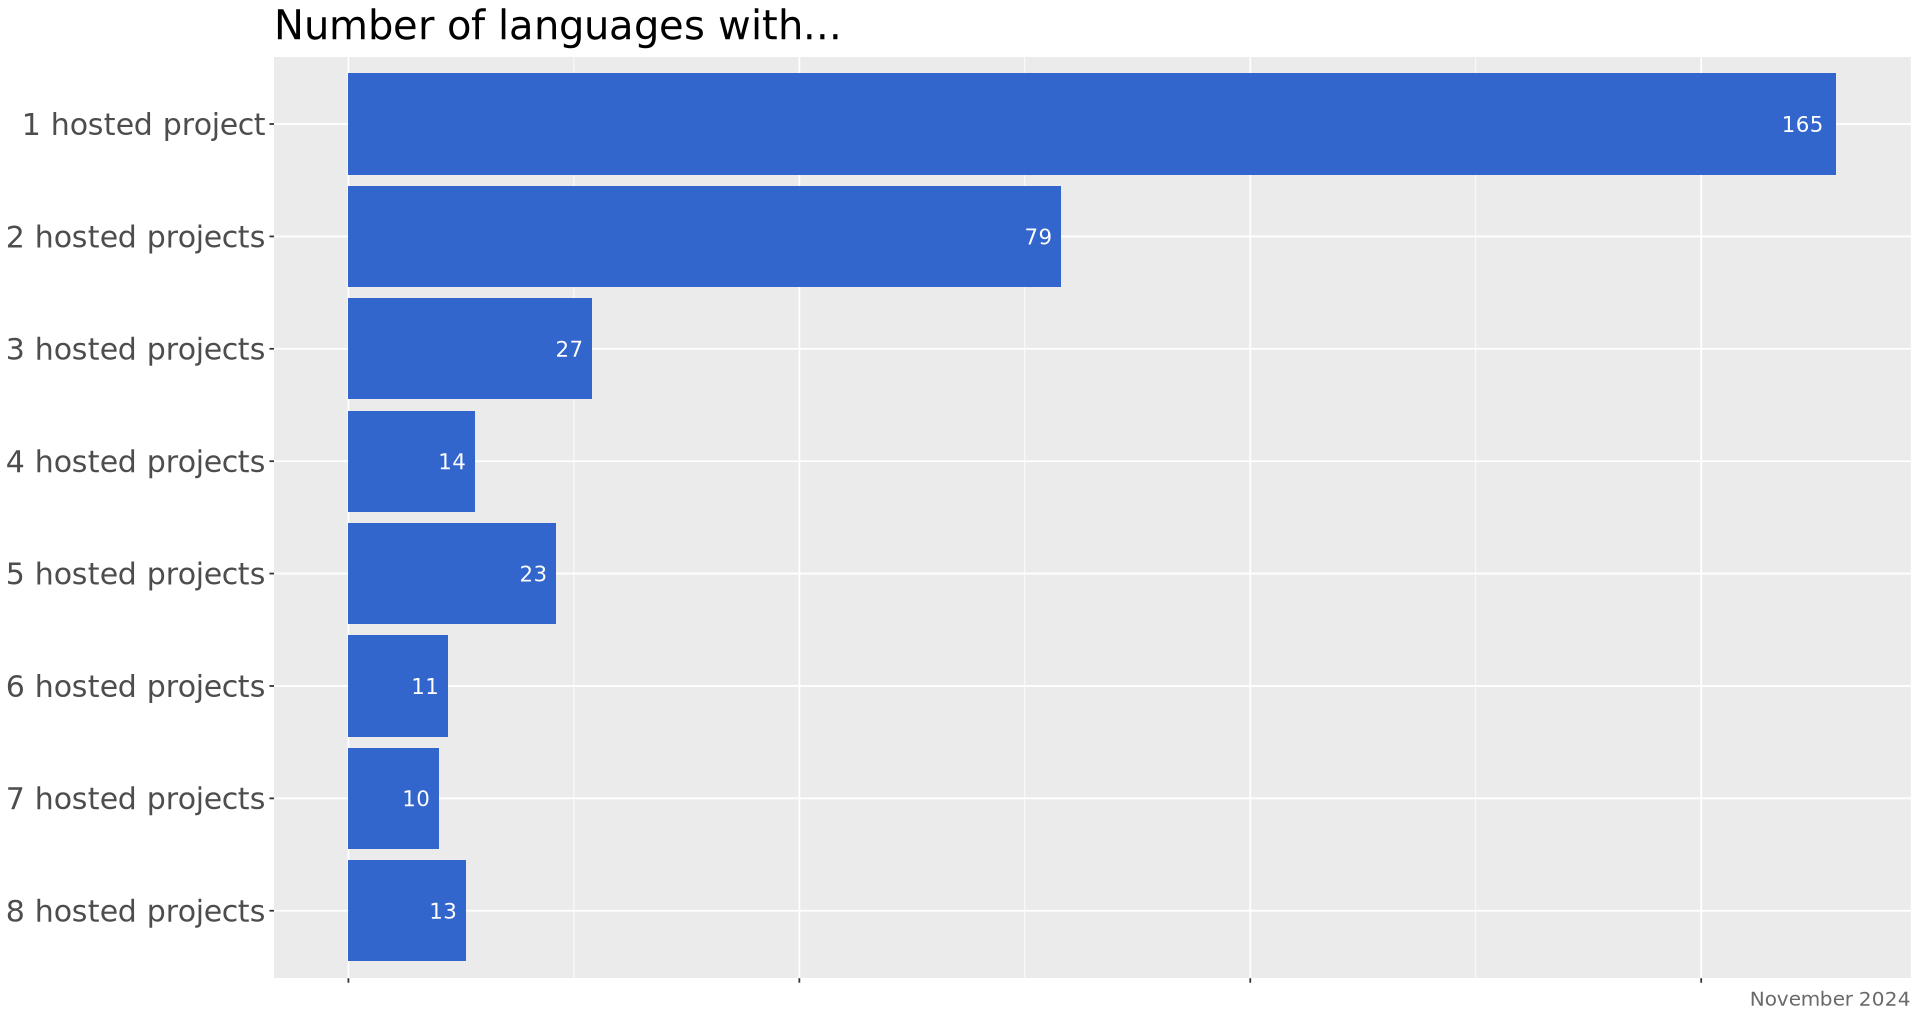

In [9]:
# Plot
as.data.frame(
    xtabs(~sum_hosted_open, 
      df %>% 
      dplyr::group_by(language_name) %>%
      dplyr::summarise(sum_hosted_open=sum(n_hosted_open)) %>%
      dplyr::ungroup() 
         )
) %>%
mutate(sum_hosted_open_text = paste0(sum_hosted_open, " hosted projects", sep="")) %>%
mutate(sum_hosted_open_text = gsub("1 hosted projects", "1 hosted project", sum_hosted_open_text)) %>%
mutate(sum_hosted_open = as.numeric(sum_hosted_open)) %>%
filter(sum_hosted_open_text!="0 hosted projects") %>%
ggplot(aes(x=reorder(sum_hosted_open_text, -sum_hosted_open), y=Freq)) + 
  geom_bar(position = position_dodge(), stat="identity", fill = "#3366CC") +
  labs(title="Number of languages with...", 
       caption="November 2024") +
  theme_sol() + 
  geom_text(aes(label = Freq), hjust = 1.3, color="white", size=4.5) +
  coord_flip() 

### How many languages have at least _x_ number of projects, hosted or in test?

In [10]:
df_ht <- df

# code for 'at least' number of projects
df_ht$`at least 1 project, hosted or test` <- ifelse(df_ht$n_all_types >= 1, 1, 0)
df_ht$`at least 2 projects, hosted or test` <- ifelse(df_ht$n_all_types >= 2, 1, 0)
df_ht$`at least 3 projects, hosted or test` <- ifelse(df_ht$n_all_types >= 3, 1, 0)
df_ht$`at least 4 projects, hosted or test` <- ifelse(df_ht$n_all_types >= 4, 1, 0)
df_ht$`at least 5 projects, hosted or test` <- ifelse(df_ht$n_all_types >= 5, 1, 0)
df_ht$`at least 6 projects, hosted or test` <- ifelse(df_ht$n_all_types >= 6, 1, 0)
df_ht$`at least 7 projects, hosted or test` <- ifelse(df_ht$n_all_types >= 7, 1, 0)
df_ht$`all 8 projects, hosted or test` <- ifelse(df_ht$n_all_types == 8, 1, 0)

# trim, gather, and aggregate
df_ht <- df_ht %>% 
  select(-c(Wikibooks, Wikinews, Wikipedia, Wikiquote, Wikisource, Wiktionary, Wikiversity, Wikivoyage, n_hosted_open, n_test_closure, n_test_initial, n_all_types, notes)) %>%
  gather(., 2:9, key="Languages with...", value="value") %>%
  dplyr::group_by(`Languages with...`) %>%
  dplyr::summarise(n=sum(value)) %>%
  dplyr::ungroup()

df_ht %>% arrange(desc(n))

Languages with...                   n   
1 at least 1 project, hosted or test  1134
2 at least 2 projects, hosted or test  483
3 at least 3 projects, hosted or test  290
4 at least 4 projects, hosted or test  216
5 at least 5 projects, hosted or test  166
6 at least 6 projects, hosted or test  124
7 at least 7 projects, hosted or test   82
8 all 8 projects, hosted or test        45

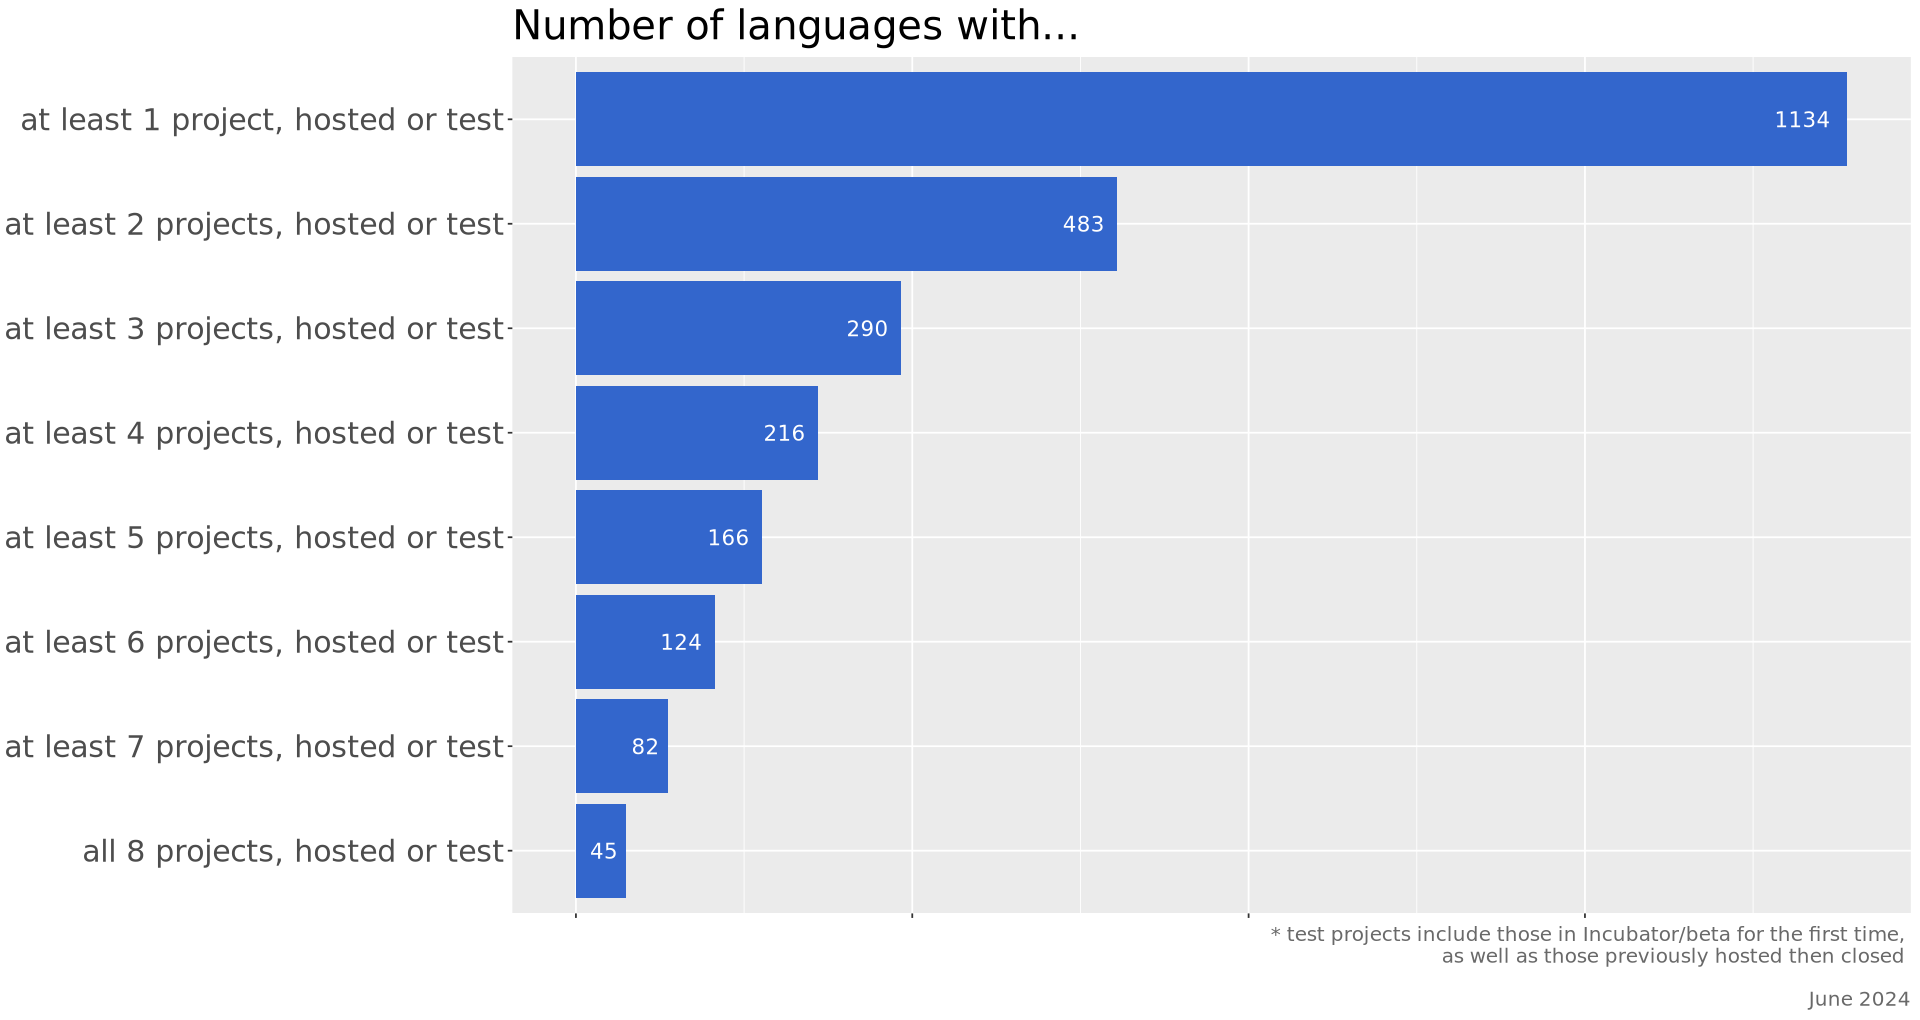

In [11]:
#Plot 
df_ht %>% ggplot(aes(x=reorder(`Languages with...`,n), y=n)) + 
  geom_bar(position = position_dodge(), stat="identity", fill = "#3366CC") +
  labs(title="Number of languages with...",
      caption="* test projects include those in Incubator/beta for the first time, \nas well as those previously hosted then closed 
\nJune 2024") +
  theme_sol() + 
  geom_text(aes(label = n), hjust = 1.3, color="white", size=4.5) +
  coord_flip()

### How many languages have at least _x_ number of test projects?

In [12]:
df_test <- df

# code 'at least' number
df_test$`at least 1 test project (initial or due to closure)` <- ifelse(df_test$n_test_closure + df_test$n_test_initial >= 1, 1, 0)
df_test$`at least 2 test projects (initial or due to closure)`<- ifelse(df_test$n_test_closure + df_test$n_test_initial >= 2, 1, 0)
df_test$`at least 3 test projects (initial or due to closure)`<- ifelse(df_test$n_test_closure + df_test$n_test_initial >= 3, 1, 0)
df_test$`at least 4 test projects (initial or due to closure)`<- ifelse(df_test$n_test_closure + df_test$n_test_initial >= 4, 1, 0)
df_test$`at least 5 test projects (initial or due to closure)`<- ifelse(df_test$n_test_closure + df_test$n_test_initial >= 5, 1, 0)
df_test$`at least 6 test projects (initial or due to closure)`<- ifelse(df_test$n_test_closure + df_test$n_test_initial >= 6, 1, 0)
df_test$`at least 7 test projects (initial or due to closure)`<- ifelse(df_test$n_test_closure + df_test$n_test_initial >= 7, 1, 0)
df_test$`all 8 test projects (initial or due to closure)`<- ifelse(df_test$n_test_closure + df_test$n_test_initial >= 8, 1, 0)

# trim, gather, and aggregate
df_test <- df_test %>% 
  select(-c(Wikibooks, Wikinews, Wikipedia, Wikiquote, Wikisource, Wiktionary, Wikiversity, Wikivoyage, n_hosted_open, n_test_closure, n_test_initial, n_all_types, notes)) %>%
  gather(., 2:9, key="Languages with...", value="value") %>%
  dplyr::group_by(`Languages with...`) %>%
  dplyr::summarise(n=sum(value)) %>%
  dplyr::ungroup()

df_test %>% arrange(desc(n))

Languages with...                                    n   
1 at least 1 test project (initial or due to closure)  1073
2 at least 2 test projects (initial or due to closure)  366
3 at least 3 test projects (initial or due to closure)  163
4 at least 4 test projects (initial or due to closure)   78
5 at least 5 test projects (initial or due to closure)   31
6 at least 6 test projects (initial or due to closure)   13
7 at least 7 test projects (initial or due to closure)    1
8 all 8 test projects (initial or due to closure)         0

### How many languages with 0 hosted projects have _x_ number of test projects?

In [13]:
df_0hosted <- df

# code for numbers
df_0hosted$`1 test project, but no hosted projects` <- ifelse(df_0hosted$n_hosted_open == 0  & (df_0hosted$n_test_initial == 1), 1, 0)
df_0hosted$`2 test projects, but no hosted projects` <- ifelse(df_0hosted$n_hosted_open == 0 & (df_0hosted$n_test_initial == 2), 1, 0) 
df_0hosted$`3 test projects, but no hosted projects` <- ifelse(df_0hosted$n_hosted_open == 0 & (df_0hosted$n_test_initial == 3), 1, 0) 
df_0hosted$`4 test projects, but no hosted projects` <- ifelse(df_0hosted$n_hosted_open == 0 & (df_0hosted$n_test_initial == 4), 1, 0) 
df_0hosted$`5 test projects, but no hosted projects`<-  ifelse(df_0hosted$n_hosted_open == 0 & (df_0hosted$n_test_initial == 5), 1, 0) 
df_0hosted$`6 test projects, but no hosted projects`<-  ifelse(df_0hosted$n_hosted_open == 0 & (df_0hosted$n_test_initial == 6), 1, 0) 
df_0hosted$`7 test projects, but no hosted projects` <- ifelse(df_0hosted$n_hosted_open == 0 & (df_0hosted$n_test_initial == 7), 1, 0) 
df_0hosted$`8 test projects, but no hosted projects` <- ifelse(df_0hosted$n_hosted_open == 0 & (df_0hosted$n_test_initial == 8), 1, 0) 

# trim, gather, and aggregate
df_0hosted <- df_0hosted %>% 
  select(-c(Wikibooks, Wikinews, Wikipedia, Wikiquote, Wikisource, Wiktionary, Wikiversity, Wikivoyage, n_hosted_open, n_test_closure, n_test_initial, n_all_types, notes)) %>%
  distinct(.) %>%
  gather(., 2:9, key="Languages with...", value="value") %>%
  dplyr::group_by(`Languages with...`) %>%
  dplyr::summarise(n=sum(value)) %>%
  dplyr::ungroup()

sum(df_0hosted$n)

[1] 785

### How many languages 0 hosted projects have _x_ number of test projects _in the Incubator_?

In [14]:
## number in incubator
proj <-
    proj_import %>% 
     filter(project!="Wikisource" & project !="Wikiversity") %>%
     select(language_name, project, `test-host`) %>%
     mutate(count=1) %>%
     dplyr::group_by(language_name, `test-host`) %>%
     dplyr::summarise(sum_count=sum(count)) %>%
     dplyr::ungroup() %>%
     spread(., key="test-host", value="sum_count") 

proj$hosted[is.na(proj$hosted)] <- 0
proj$test[is.na(proj$test)] <- 0
proj$`test (closed)`[is.na(proj$`test (closed)`)] <- 0

## number of languages with projects in the Incubator
#nrow(proj %>% filter(test>0)) # excludes ones with only closed projects
nrow(proj %>% filter(test>0|`test (closed)`>0)) # incldes ones any test projects

##number of languages with ONLY firstime TESTS
nrow(proj %>% filter(test>0 & hosted==0))

##TABLE
proj <- proj %>% filter(test>0) %>% dplyr::rename("number of test projects"="test") 
proj <- as.data.frame(xtabs(~`number of test projects`, proj))


head(proj, n=15)

`summarise()` has grouped output by 'language_name'. You can override using the
`.groups` argument.


[1] 1035

[1] 767

number.of.test.projects Freq
1 1                       720 
2 2                       185 
3 3                        54 
4 4                        25 
5 5                         9 
6 6                         8

### How many languages with 0 hosted projects have _x_ number of Active or Substantial test projects in the Incubator?

In [15]:
# Query substantial incubator projects
sql_text <- readLines(here("02_wrangling_scripts/queries/substantial_query.txt"))
sql_string <- paste(sql_text, collapse = "\n")
substantial_import <- wmfdata$spark$run(sql_string)

In [16]:
# Query active incubator projects
sql_text <- readLines(here("02_wrangling_scripts/queries/active_query.txt"))
sql_string <- paste(sql_text, collapse = "\n")
active_import <- wmfdata$spark$run(sql_string)

In [17]:
# create dataframe with substantial/active indicators
df_sa <- (substantial_import %>% select(prefix) %>% mutate(substantial="Yes"))%>% 
  full_join(., (active_import %>% select(prefix) %>% mutate(active="Yes")), by="prefix") %>%
  filter(active=="Yes"|substantial=="Yes") %>%
  left_join(., lang_import %>% select(language_name, prefix), by="prefix")
df_sa$substantial[is.na(df_sa$substantial)] <- "No"
df_sa$active[is.na(df_sa$active)] <- "No"

# connect filter proj for substantial/active or hosted only
proj_sa <- proj_import %>%
  left_join(., df_sa, by=c("language_name", "prefix")) %>%
  filter(substantial=="Yes" | active=="Yes" | `test-host`=="hosted") %>% 
  select(prefix, language_name, `test-host`, substantial, active) %>%
  arrange(language_name)

In [18]:
## create counts
proj_sa <-
    proj_sa %>% 
     dplyr::select(language_name, `test-host`) %>%
     dplyr::mutate(count=1) %>%
     dplyr::group_by(language_name, `test-host`) %>%
     dplyr::summarise(sum_count=sum(count)) %>%
     dplyr::ungroup() %>%
     spread(., key="test-host", value="sum_count") 
proj_sa$hosted[is.na(proj_sa$hosted)] <- 0
proj_sa$test[is.na(proj_sa$test)] <- 0

## Number of languages with substantial/active projects in the Incubator
#nrow(proj_sa %>% filter(test>0)) # excludes ones with only closed projects
nrow(proj_sa %>% filter(test>0|`test (closed)`>0)) # incldes ones any test projects

## Number of languages with ONLY FIRSTTIME TESTS that are substantial/active
nrow(proj_sa %>% filter(test>0 & hosted==0)) 

## Distribution table
proj_sa <- proj_sa %>% filter(test>0) %>% dplyr::rename("number of test projects"="test") 
proj_sa <- as.data.frame(xtabs(~`number of test projects`, proj_sa))
proj_sa

`summarise()` has grouped output by 'language_name'. You can override using the
`.groups` argument.


[1] 435

[1] 284

number.of.test.projects Freq
1 1                       353 
2 2                        46 
3 3                        10 
4 4                         4 
5 6                         1

## Metrics: project-level

### How many languages have a hosted or test Wikipedia?

In [19]:
as.data.frame(xtabs(~Wikipedia, df %>% filter(grepl("hosted|test", Wikipedia))))

Wikipedia     Freq
1 hosted        340 
2 test          736 
3 test (closed)  13

### How many languages have a hosted or test Wiktionary?

In [20]:
as.data.frame(xtabs(~Wiktionary, df %>% filter(grepl("hosted|test", Wiktionary))))

Wiktionary    Freq
1 hosted        171 
2 test          274 
3 test (closed)  24

### How many languages have a hosted or test Wikisource?

In [21]:
as.data.frame(xtabs(~Wikisource, df %>% filter(grepl("hosted|test", Wikisource))))

Wikisource    Freq
1 hosted         78 
2 test          132 
3 test (closed)   2

### How many languages have a hosted or test Wikibooks?

In [22]:
as.data.frame(xtabs(~Wikibooks, df %>% filter(grepl("hosted|test", Wikibooks))))

Wikibooks     Freq
1 hosted        77  
2 test          93  
3 test (closed) 44

### How many languages have a hosted or test Wikinews?

In [23]:
as.data.frame(xtabs(~Wikinews, df %>% filter(grepl("hosted|test", Wikinews))))

Wikinews      Freq
1 hosted         31 
2 test          118 
3 test (closed)   5

### How many languages have a hosted or test Wikiquote?

In [24]:
as.data.frame(xtabs(~Wikiquote, df %>% filter(grepl("hosted|test", Wikiquote))))

Wikiquote     Freq
1 hosted        74  
2 test          92  
3 test (closed) 23

### How many languages have a hosted or test Wikiversity?

In [25]:
as.data.frame(xtabs(~Wikiversity, df %>% filter(grepl("hosted|test", Wikiversity))))

Wikiversity Freq
1 hosted      17  
2 test        37

### How many languages have a hosted or test Wikivoyage?

In [26]:
as.data.frame(xtabs(~Wikivoyage, df %>% filter(grepl("hosted|test", Wikivoyage))))

Wikivoyage Freq
1 hosted      27 
2 test       132

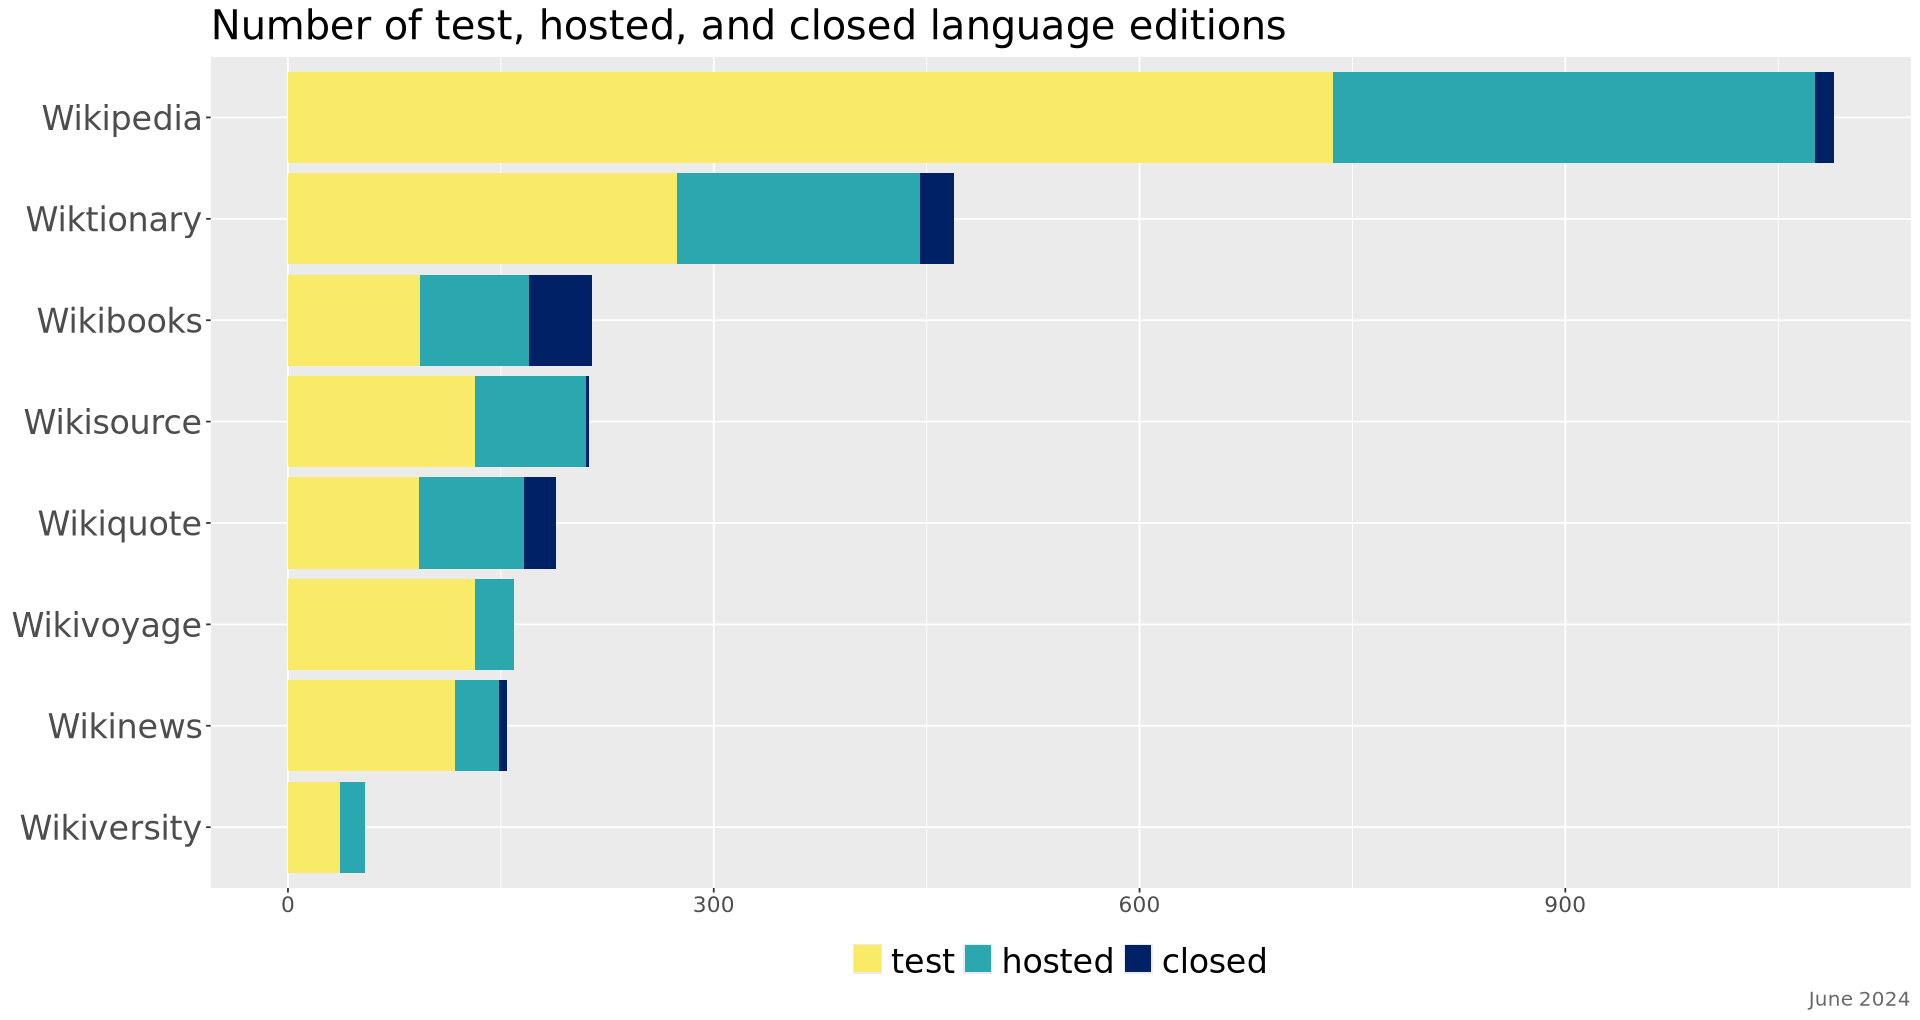

In [27]:
# SUMMARY PLOT

# gather and crosstab
df_summary <- as.data.frame(xtabs(~project+type, df %>% gather("project", "type", Wikibooks:Wiktionary) %>% filter(grepl("hosted|test", type)))) 

# order factors
df_summary$type <- as.character(df_summary$type)
df_summary$type[df_summary$type=="test (closed)"] <- "closed"
df_summary$type <- factor(df_summary$type, levels=c("closed", "hosted", "test"))

# plot
options(repr.plot.width=16, repr.plot.height=8.5)
df_summary %>%
    ggplot(aes(x=reorder(project,Freq), y=Freq, fill=type)) + 
      geom_bar(stat="identity") +
      labs(title="Number of test, hosted, and closed language editions",
          caption="June 2024") +
      theme_sol() + 
   # geom_text(aes(label=Freq, color=type), position = position_stack(vjust = 0.5)) + # add to see value labels
      coord_flip() +
      scale_fill_manual(values=c("#002165", "#2Ba8AF", "#F9ea68")) +
      scale_color_manual(values = c("white", "white", "black")) +
      theme(legend.position="bottom", legend.title=element_blank(), legend.text=element_text(size=20, vjust=0.1),
            axis.text.x=element_text(size=13),  axis.text.y=element_text(size=20)) +
      guides(fill = guide_legend(reverse = TRUE))

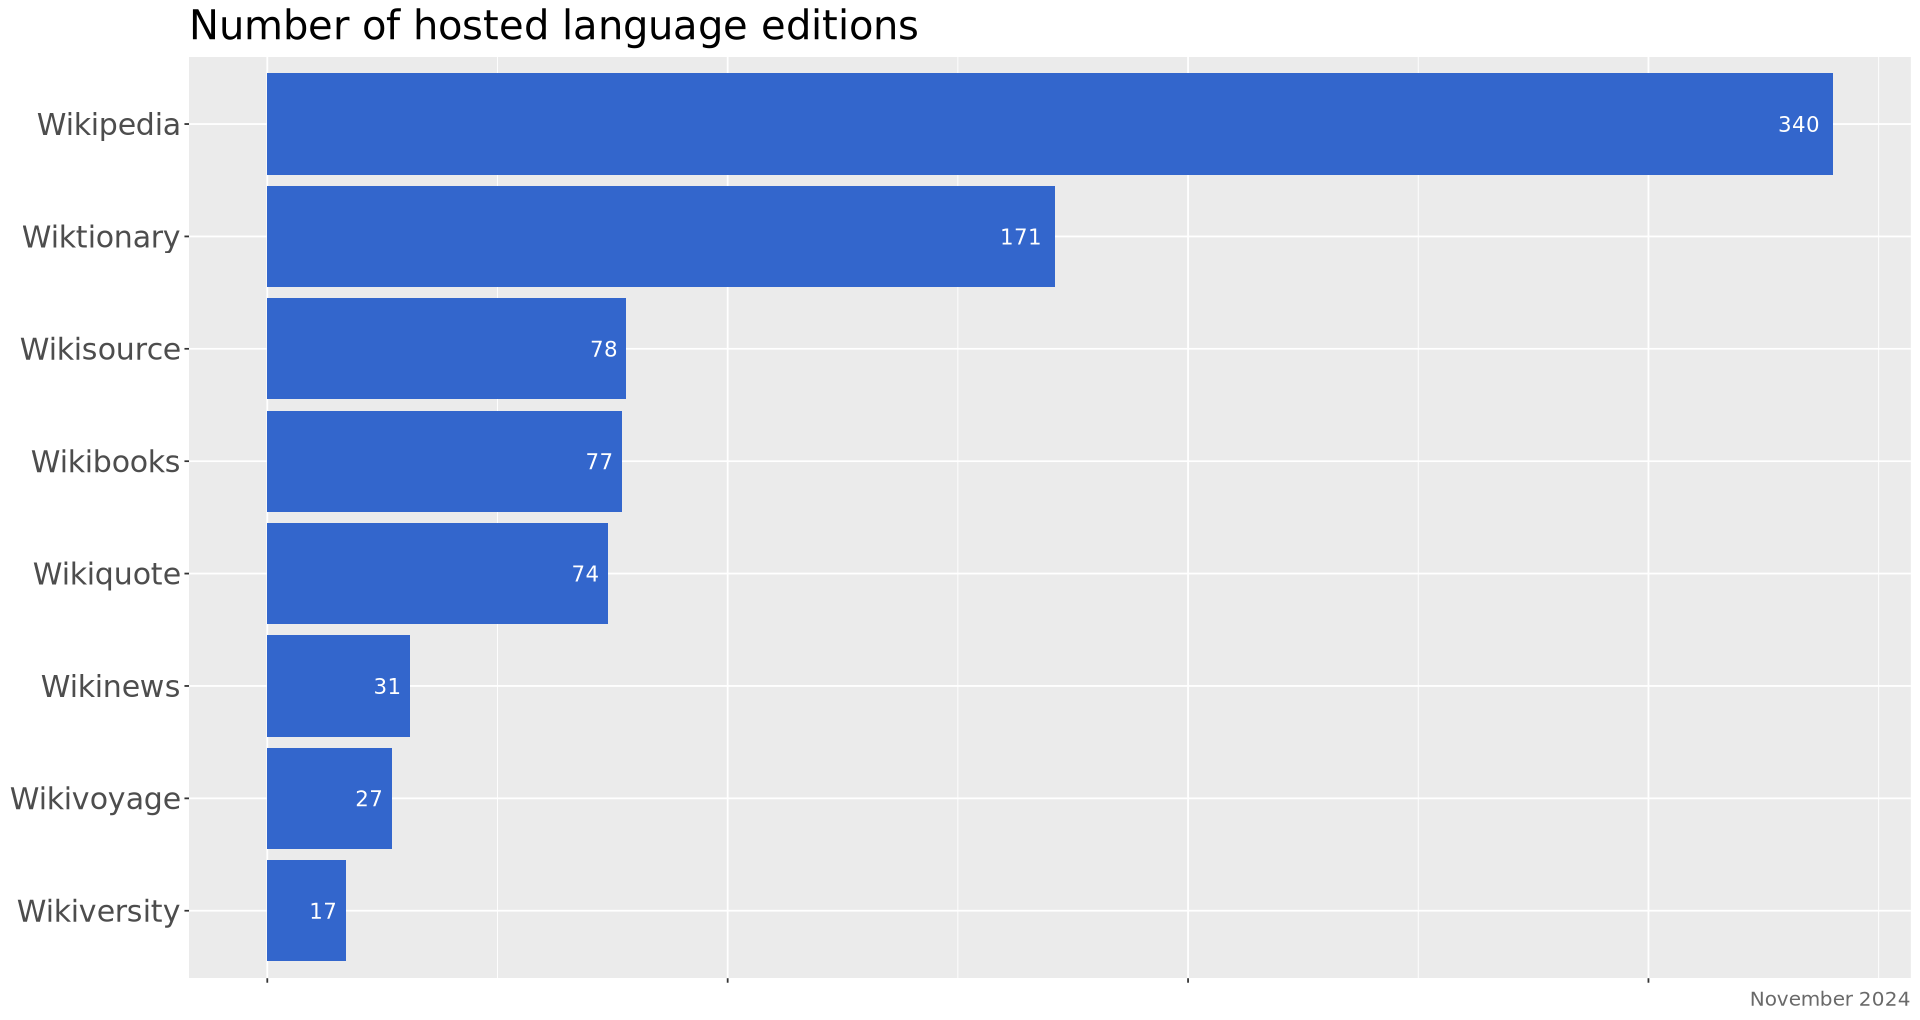

In [28]:
# SUMMARY PLOT - hosted only

# plot
options(repr.plot.width=16, repr.plot.height=8.5)
df_summary %>%
  filter(type=='hosted') %>%
    ggplot(aes(x=reorder(project,Freq), y=Freq, fill=type)) + 
      geom_bar(stat="identity", fill = "#3366CC") +
      labs(title="Number of hosted language editions",
          caption="November 2024") +
    theme_sol() + 
  geom_text(aes(label = Freq), hjust = 1.3, color="white", size=4.5) +
  coord_flip()

In [29]:
df_summary %>% 
 dplyr::group_by(type) %>%
 dplyr::summarise(sumFreq=sum(Freq))

type   sumFreq
1 closed  111   
2 hosted  815   
3 test   1614

In [30]:
# PLOT PROJECT STATUSES FOR ALL LANGUAGES

# create long df
df_long = as.data.frame(xtabs(~language_name+project+type, df%>%gather("project", "type", Wikibooks:Wiktionary))) %>% 
  dplyr::rename(value=Freq) %>% 
  filter(grepl("host|test" ,type)) %>%
  filter(value==1)

# factor
df_long$type <- as.character(df_long$type)
df_long$type[df_long$type=="test (closed)"] <- "closed"
df_long$type <- factor(df_long$type, levels=c(   "closed", "hosted", "test"))

# plot
options(repr.plot.width=16, repr.plot.height=260)
png("outputs/state_of_languages_visualized.png", 
    width = 1200, height = 32000) # write following viz to png
df_long %>%
  mutate(language_name = fct_reorder(language_name, desc(language_name))) %>%
  ggplot(aes(x=language_name, y=value, fill=type)) +
  geom_bar(stat="identity") +
  theme(axis.text.x=element_blank(), axis.title=element_blank(), strip.text=element_text(size=15),
        plot.title=element_text(size=23), axis.text.y=element_text(size=15), 
        legend.text=element_text(size=15), legend.position="top", legend.justification="right", legend.title=element_blank()) +
  facet_grid(.~project) +  
  scale_fill_manual(values=c("#002165", "#2Ba8AF", "#F9ea68")) +
  labs(title="State of languages: project coverage and status(es)") +
  guides(fill = guide_legend(reverse = TRUE)) +
  coord_flip() +
 # geom_text(aes(label=language_name), y=0.5, size=3) + # this works but you can't see black texton dark blue
  geom_label(aes(label = language_name), y=0.5, fill = "white", size=4) 
dev.off()

png 
  2

### How many substantial test projects in the Incubator?
Per [Incubator:wikis](https://incubator.wikimedia.org/wiki/Incubator:Wikis), "substantial" test projects have "**at least 25 mainspace pages**"

In [31]:
substantial = substantial_import %>% mutate(prefixdup=prefix) %>% separate(., col=prefixdup, into=c("project_type", "lang_code"))
print(nrow(substantial))
as.data.frame(xtabs(~project_type, (substantial)))

[1] 550


project_type Freq
1 Wb            25 
2 Wn            35 
3 Wp           283 
4 Wq            32 
5 Wt           139 
6 Wy            36

### How many active test projects in the Incubator?

Active test projects have had **at least one new page created in the mainspace since 2023**; as, per [Incubator:wikis](https://incubator.wikimedia.org/wiki/Incubator:Wikis), "active" test projects have "some active content creation since the beginning of 2023"

In [32]:
active = active_import %>% mutate(prefixdup=prefix) %>% separate(., col=prefixdup, into=c("project_type", "lang_code"))
print(nrow(active))
as.data.frame(xtabs(~project_type, (active)))

[1] 0


Freq

### How many substantial _OR_ active test projects in the Incubator?


In [33]:
subact <- substantial %>% select(prefix, project_type) %>% mutate(subst="Yes") %>%
        full_join(., (active %>% select(prefix, project_type) %>% mutate(act="Yes")), by=c("prefix", "project_type"))
print(nrow(subact))
as.data.frame(xtabs(~project_type, subact))

[1] 550


project_type Freq
1 Wb            25 
2 Wn            35 
3 Wp           283 
4 Wq            32 
5 Wt           139 
6 Wy            36

### How many projects have graduated?


In [34]:
proj_import %>%
 filter(source=="Graduate") %>%
 filter(project!="Wikiversity" & project!="Wikisource") %>% 
 select(source, language_name) %>%
 mutate(count=1) %>%
 dplyr::group_by(source) %>%
 dplyr::summarise(sum_count=sum(count)) %>%
 dplyr::ungroup()

source   sum_count
1 Graduate 201

### How many languages with graduated projects?


In [35]:
proj_import %>%
 filter(source=="Graduate") %>%
 filter(project!="Wikiversity" & project!="Wikisource") %>% 
 select(source, language_name) %>%
 distinct(.) %>%
 mutate(count=1) %>%
 dplyr::group_by(source) %>%
 dplyr::summarise(sum_count=sum(count)) %>%
 dplyr::ungroup()

source   sum_count
1 Graduate 159

### How many projects, on average, has each language had graduate from the Incubator?

In [36]:
proj_import %>%
 filter(source=="Graduate") %>%
 filter(project!="Wikiversity" & project!="Wikisource") %>% 
 select(source, language_name) %>%
 mutate(count=1) %>%
 dplyr::group_by(language_name) %>%
 dplyr::summarise(sum_count=sum(count)) %>%
 dplyr::ungroup() %>%
 mutate(all="all") %>%
 dplyr::group_by(all) %>%
 mutate(mean_counts=mean(sum_count)) %>%
 mutate(min_counts=min(sum_count)) %>%
 mutate(max_counts=max(sum_count)) %>%
 select(all, mean_counts, min_counts, max_counts) %>%
 distinct(.)

all mean_counts min_counts max_counts
1 all 1.264151    1          5

### How many projects currently in Incubator?

In [37]:
proj_import %>%
 filter(source=="Incubator") %>%
 select(source, language_name) %>%
 mutate(count=1) %>%
 dplyr::group_by(source) %>%
 dplyr::summarise(sum_count=sum(count)) %>%
 dplyr::ungroup()

source    sum_count
1 Incubator 1522

### How many languages with projects currently in Incubator?

In [38]:
proj_import %>%
 filter(source=="Incubator") %>%
 select(source, language_name) %>%
 distinct(.) %>%
 mutate(count=1) %>%
 dplyr::group_by(source) %>%
 dplyr::summarise(sum_count=sum(count)) %>%
 dplyr::ungroup()

source    sum_count
1 Incubator 1024

### How many projects, on average, does each language have in the Incubator?

In [39]:
proj_import %>%
 filter(source=="Incubator") %>%
 select(source, language_name) %>%
 mutate(count=1) %>%
 dplyr::group_by(language_name) %>%
 dplyr::summarise(sum_count=sum(count)) %>%
 dplyr::ungroup() %>%
 mutate(all="all") %>%
 dplyr::group_by(all) %>%
 mutate(mean_counts=mean(sum_count)) %>%
 mutate(min_counts=min(sum_count)) %>%
 mutate(max_counts=max(sum_count)) %>%
 select(all, mean_counts, min_counts, max_counts) %>%
 distinct(.)

all mean_counts min_counts max_counts
1 all 1.486328    1          6

## Top Languages breakdowns


For state of top 20 languages, see [state_of_languages-top20.ipynb](https://gitlab.wikimedia.org/repos/research/incubator-data-exploration/-/blob/main/04_analysis/state_of_languages-top20.ipynb?ref_type=heads)